In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout



## Load Data Set

In [ ]:
def load_data(path):
  train_x = sorted(glob(os.path.join(path, 'training','images', '*.tif')))
  train_y = sorted(glob(os.path.join(path, 'training','1st_manual', '*.gif')))

  test_x = sorted(glob(os.path.join(path, 'test','images', '*.tif')))
  test_y = sorted(glob(os.path.join(path, 'test','1st_manual', '*.gif')))

  return (train_x,train_y),(test_x,test_y)

# Main Function

In [ ]:
if __name__ == "__main__":
  np.random.seed(42)
  data_path = "/content/drive/MyDrive/Retina Blood Vessel Dataset"
  (train_x,train_y),(test_x,test_y) = load_data(data_path)
## Length of train and test data
  print(f"Train: {len(train_x),len(train_y)}")
  print(f"Test: {len(test_x),len(test_y)}")

  ## Create directories
  create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/train/image/")
  create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/train/mask")
  create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/test/image/")
  create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/test/mask/")

  ## Data Augmentation
  augment_data(train_x,train_y,"/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/train",augment=True)
  augment_data(train_x,train_y,"/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/test",augment=False)





Train: (20, 20)
Test: (20, 20)


100%|██████████| 20/20 [00:01<00:00, 13.39it/s]


## Data Augmentation - To Create more data

#### Create Folders to store augmented data

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:

def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting names """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(X) == 1:
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{index}.jpg"
                tmp_mask_name = f"{name}_{index}.jpg"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1


## UNet Architecture

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0]

## Model *Training*

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision



H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files", "model.h5")
    csv_path = os.path.join("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files", "data.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2"
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "test")

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

    train_steps = len(train_x)//batch_size
    valid_setps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_setps += 1

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=[Recall(), Precision()])
    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_setps,
        callbacks=callbacks
    )

Train: 120 - 120
Valid: 20 - 20
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.2617 - recall: 0.2298 - precision: 0.8246
Epoch 1: val_loss improved from inf to 0.48658, saving model to /content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 147s 2s/step - loss: 0.2617 - recall: 0.2298 - precision: 0.8246 - val_loss: 0.4866 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.1762 - recall: 0.2946 - precision: 0.9186
Epoch 2: val_loss improved from 0.48658 to 0.35550, saving model to /content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/model.h5
60/60 [==============================] - 38s 635ms/step - loss: 0.1762 - recall: 0.2946 - precision: 0.9186 - val_loss: 0.3555 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 0.1562 - recall: 0.3090 - precision: 0.9324
Epoch 3: val_loss improved from 0.35550 to 0.30740, saving model to /content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/model.h5
60/60 [==============================] - 37s 619ms/step - loss: 0.1562 - recall: 0.3090 - prec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Evaluation & Prediction


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    ori_x_title = cv2.putText(ori_x.copy(), 'Original Image', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    ori_y_title = cv2.putText(ori_y.copy(), 'Original Mask', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    y_pred_title = cv2.putText(y_pred.copy(), 'Predicted Mask', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Concatenate images with titles
    cat_images = np.concatenate([ori_x_title, line, ori_y_title, line, y_pred_title], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Save the results in this folder """
    create_dir("/content/drive/MyDrive/Retina Blood Vessel Dataset/Results")

    """ Load the model """

    model = tf.keras.models.load_model("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/model.h5")

    """ Load the dataset """
    dataset_path = os.path.join("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2", "test")
    test_x, test_y = load_data(dataset_path)

    """ Make the prediction and calculate the metrics values """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting name """
        name = x.split("/")[-1].split(".")[0]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Prediction """
        y_pred = model.predict(np.expand_dims(x, axis=0))[0]
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)
        y_pred = np.squeeze(y_pred, axis=-1)

        """ Saving the images """
        save_image_path = f"/content/drive/MyDrive/Retina Blood Vessel Dataset/Results/{name}.png"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculate the metrics """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Saving """
    df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/score.csv")

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


  5%|▌         | 1/20 [00:11<03:34, 11.28s/it]

1/1 [==============================] - 7s 7s/step


 10%|█         | 2/20 [00:22<03:17, 10.99s/it]

1/1 [==============================] - 7s 7s/step


 15%|█▌        | 3/20 [00:33<03:08, 11.06s/it]

1/1 [==============================] - 8s 8s/step


 20%|██        | 4/20 [00:44<02:55, 10.99s/it]

1/1 [==============================] - 9s 9s/step


 25%|██▌       | 5/20 [00:54<02:44, 10.95s/it]

1/1 [==============================] - 7s 7s/step


 30%|███       | 6/20 [01:05<02:32, 10.91s/it]

1/1 [==============================] - 7s 7s/step


 35%|███▌      | 7/20 [01:13<02:07,  9.78s/it]

1/1 [==============================] - 10s 10s/step


 40%|████      | 8/20 [01:23<01:59,  9.99s/it]

1/1 [==============================] - 10s 10s/step


 45%|████▌     | 9/20 [01:35<01:56, 10.57s/it]

1/1 [==============================] - 10s 10s/step


 50%|█████     | 10/20 [01:46<01:47, 10.77s/it]

1/1 [==============================] - 11s 11s/step


 55%|█████▌    | 11/20 [02:08<02:06, 14.01s/it]

1/1 [==============================] - 8s 8s/step


 60%|██████    | 12/20 [02:16<01:39, 12.40s/it]

1/1 [==============================] - 8s 8s/step


 65%|██████▌   | 13/20 [02:27<01:24, 12.01s/it]

1/1 [==============================] - 14s 14s/step


 70%|███████   | 14/20 [02:49<01:29, 14.99s/it]

1/1 [==============================] - 11s 11s/step


 75%|███████▌  | 15/20 [03:11<01:25, 17.00s/it]

1/1 [==============================] - 8s 8s/step


 80%|████████  | 16/20 [03:22<01:00, 15.16s/it]

1/1 [==============================] - 9s 9s/step


 85%|████████▌ | 17/20 [03:33<00:42, 14.00s/it]

1/1 [==============================] - 8s 8s/step


 90%|█████████ | 18/20 [03:42<00:25, 12.58s/it]

1/1 [==============================] - 8s 8s/step


 95%|█████████▌| 19/20 [03:54<00:12, 12.25s/it]

1/1 [==============================] - 10s 10s/step


100%|██████████| 20/20 [04:05<00:00, 12.29s/it]


Accuracy: 0.95490
F1: 0.58552
Jaccard: 0.41441
Recall: 0.94690
Precision: 0.42569


## Testing on single images

1/1 [==============================] - 14s 14s/step


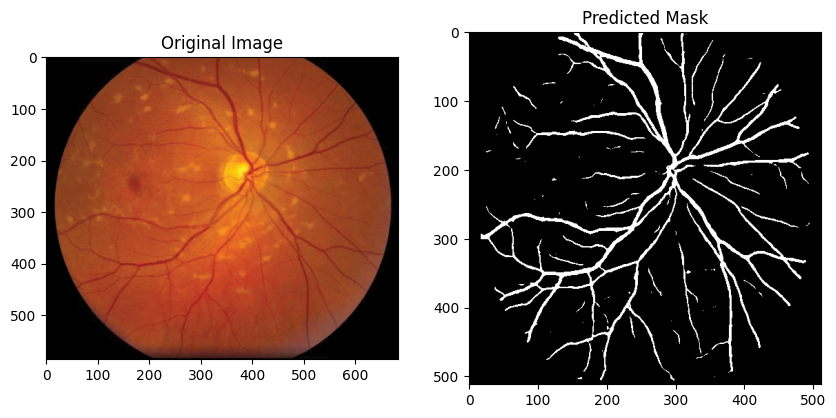

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

H = 512
W = 512

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))  # Resize if necessary
    x = x / 255.0
    x = x.astype(np.float32)
    return x

if __name__ == "__main__":
    """ Load the model """
    model_path = "/content/drive/MyDrive/Retina Blood Vessel Dataset/new_data2/files/model.h5"
    model = tf.keras.models.load_model(model_path)

    """ Load and process the image """
    image_path = "/content/drive/MyDrive/binary_mask/image/Fundus-photography-of-a-patient-with-Stargardt-macular-dystrophy-shows-yellowish-flecks.png"
    ori_x = cv2.imread(image_path, cv2.IMREAD_COLOR)
    x = read_image(image_path)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1) * 255

    """ Display the images """
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(ori_x, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(y_pred, cmap='gray')

    plt.show()
